In [36]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as distance

%matplotlib inline

In [2]:
# Load data
data_folder = 'Data/Neuronal Differentiation/'

fname1 = 'Neuronal_Differentiation-Expression_Matrix.txt'
fname2 = 'Neuronal_Differentiation-Labels.txt'
fname3 = 'Neuronal_Differentiation-Cell_Line.txt'

fpath1 = data_folder + fname1
fpath2 = data_folder + fname2
fpath3 = data_folder + fname3

df_copyNumber = pd.read_table(fpath1)
df_copyNumber = df_copyNumber.T

df_map = pd.read_table(fpath2)
df_cell = pd.read_table(fpath3)

time_stamp = df_map['x']

df_copyNumber['Time'] = df_map['x'].values
df_copyNumber['Cell'] = df_cell['x'].values

df_copyNumber.set_index(['Time', 'Cell'], append=True, inplace=True)

In [3]:
# Configuration
class Config(object):
    def __init__(self):
        Config.Standardise = True
        
config = Config()

### Reduce dimensions

Reduce the number of dimensions by t-SNE.

In [4]:
# Reduce dimensions
X = df_copyNumber.values
d = 2

if config.Standardise:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

#from sklearn.manifold import TSNE
#X = TSNE(n_components=d).fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=d).fit(X)
X = pca.transform(X)

In [5]:
# Save data
#np.save('data.npy', X)
X = np.load('data.npy')

### Assess the distributional properties

After reducing the number of dimensions from a very large number into two, we are able to visualise the cells' data on a 2D plane. We also plot the histogram and Gaussian kernel for each of the two dimensions, so that we have an initial diagnosis of the feasibility of applying mixture model.

/Users/vic/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


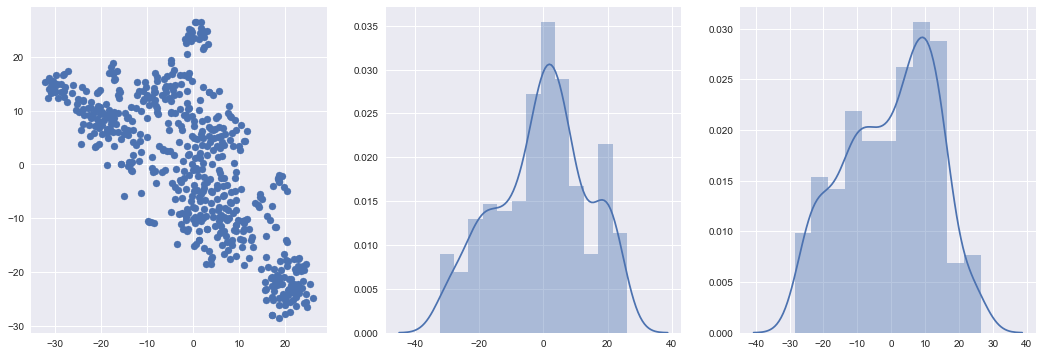

In [6]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(131)
ax.scatter(X[:,0],X[:,1])
ax = fig.add_subplot(132)
sns.distplot(X[:,0])
ax = fig.add_subplot(133)
sns.distplot(X[:,1])

In [55]:
df = pd.DataFrame(X, columns=['Feature1','Feature2'])

/Users/vic/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


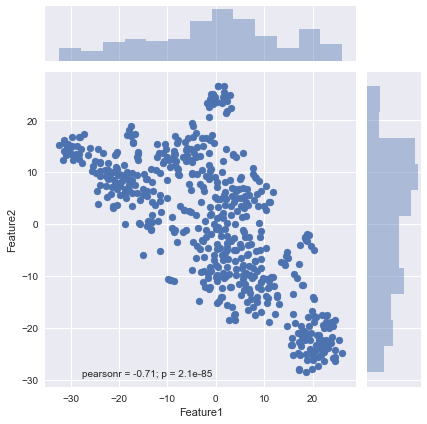

In [59]:
sns.jointplot(x='Feature1',y='Feature2', data=df)

In [52]:
X

array([[ 24.601309 , -18.46266  ],
       [ 24.67979  , -26.43184  ],
       [ 21.885044 , -22.776682 ],
       ...,
       [-17.061495 ,  15.820728 ],
       [  2.4021142,  23.642815 ],
       [  1.1837732,  23.372383 ]], dtype=float32)

In [46]:
def hcluster(X, n_states, plot_type):

    # Identify the states (clusters)
    n_features = X.shape[1]

    from sklearn import mixture

    dpgmm = mixture.GaussianMixture(
            n_components=n_states, 
            covariance_type='full',
            init_params='random',
            verbose=0, verbose_interval=100,
            n_init=1, 
            tol=1e-6, max_iter=1000,
            random_state=1).fit(X)
    
    state_assignment = dpgmm.predict(X)
    states = np.unique(state_assignment)
    means = dict(zip(dpgmm.predict(dpgmm.means_), dpgmm.means_))
    
    xmin = np.min(X[:,0])*1.1
    xmax = np.max(X[:,0])*1.1
    ymin = np.min(X[:,1])*1.1
    ymax = np.max(X[:,1])*1.1
    
    
    # Combined
    if plot_type=='Static':
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)
        for n, state in enumerate(states):
            mask = state_assignment==state
            Xs = X[mask]
            ax.scatter(Xs[:,0], Xs[:,1], alpha=0.8, label=state)
            ax.scatter(means[state][0], means[state][1], s=200, marker='*', c='k')
            ax.set_xlim([xmin, xmax])
            ax.set_ylim([ymin, ymax])
            
            covariances = dpgmm.covariances_[n][:2, :2]
            v, w = np.linalg.eigh(covariances)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan2(u[1], u[0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            ell = mpl.patches.Ellipse(dpgmm.means_[n, :2], v[0], v[1],
                                  180 + angle)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.4)
            ax.add_artist(ell)
            
        plt.legend()

    
    # Dynamics
    # Construct the state-time data frame
    df_state = pd.DataFrame(
        data={'Time': df_copyNumber.index.get_level_values(level=1),
              'State': state_assignment
             })

    col_dim = []
    for i in range(d):
        df_state['Dim_'+str(i+1)] = X[:,i]
        col_dim.append('Dim_'+str(i+1))
        
    times = time_stamp.unique()
    n_col = 7
    n_time = times.shape[0]
    n_row = n_time // n_col
    n_row +=  n_time % n_col
    pos = range(1, n_time+1)

    if plot_type=='Dynamic':
        fig = plt.figure(figsize=(2*n_col,2*n_row))
        for i, time in enumerate(times):
            ax = fig.add_subplot(n_row, n_col, pos[i])
            for state in states:
                mask = (state_assignment==state) & (df_state['Time']==time)
                data = df_state[mask][col_dim]
                ax.scatter(data.iloc[:,0], data.iloc[:,1], alpha=.8, label=state, s=50)
        
                ax.scatter(means[state][0], means[state][1], s=100, marker='*', c='k')
                ax.set_title('T = '+str(time))
                ax.set_xlim([xmin, xmax])
                ax.set_ylim([ymin, ymax])

        plt.legend()
        plt.tight_layout()

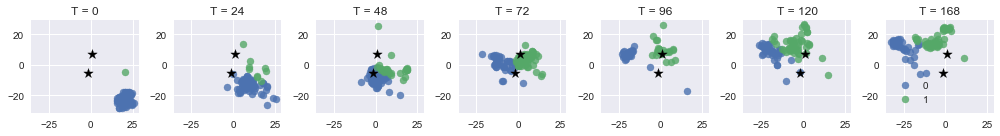

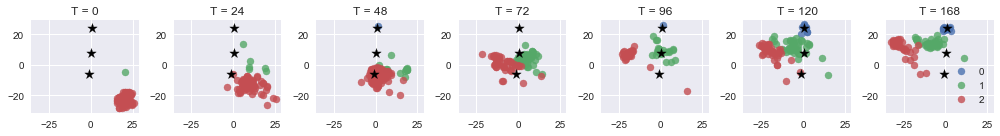

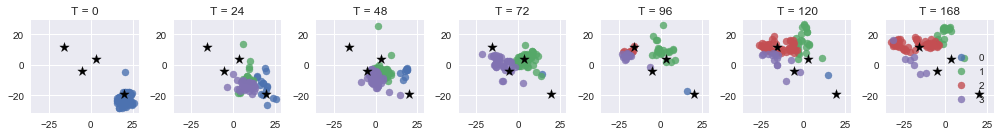

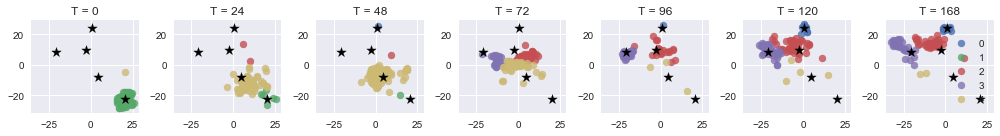

In [42]:
hcluster(X,2,'Dynamic')
hcluster(X,3,'Dynamic')
hcluster(X,4,'Dynamic')
hcluster(X,5,'Dynamic')

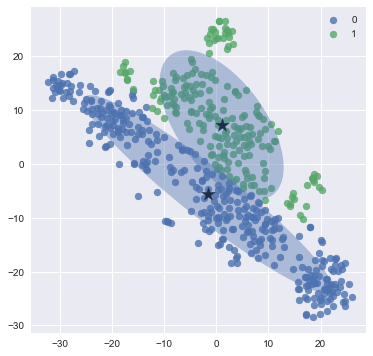

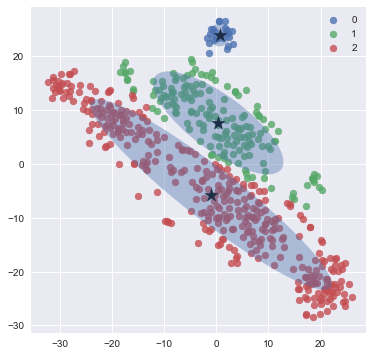

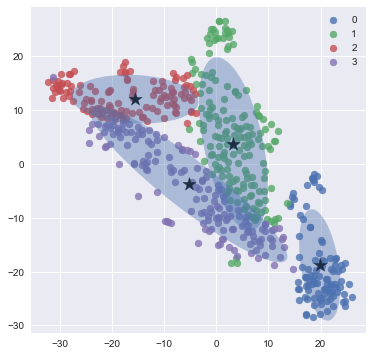

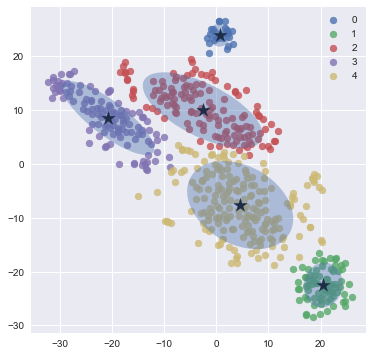

In [47]:
hcluster(X,2,'Static')
hcluster(X,3,'Static')
hcluster(X,4,'Static')
hcluster(X,5,'Static')

### Using time information to identify the order of states (clusters) in the reference of the cells' internal clock

We calculate the proportion of each state in the sample at each time point. We expect the evolution of state proportions can imply the transitions of states over time. To see this, we check three forms of graphs.

(1) Pie chart showing the propotions over time

(2) Data points and their associated state status over time

(3) The time-series line chart of the proportions of each state

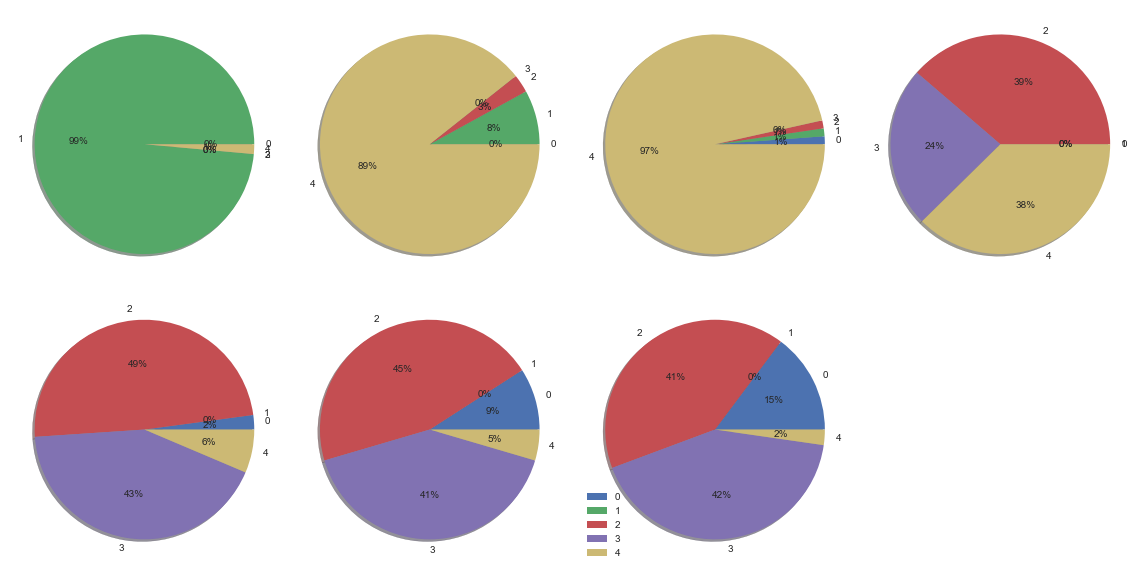

In [83]:
times = time_stamp.unique()

n_col = 4
n_time = times.shape[0]
n_row = n_time // n_col
n_row +=  n_time % n_col
pos = range(1, n_time+1)

fig = plt.figure(figsize=(4*n_col,4*n_row))
states_freq = []
for i, time in enumerate(times):
    mask = df_state['Time']==time
    state_dist = df_state[mask]['State'].values
    
    state_freq = []
    for state in states:
        state_freq.append((state_dist[state_dist==state]).shape[0])
    
    states_freq.append(state_freq)
    ax = fig.add_subplot(n_row, n_col, pos[i])
    #ax.hist(state_dist)
    #ax.set_ylim([0,70])
    ax.pie(state_freq, autopct='%.0f%%', labels=states, shadow=True)
    #ax.set_xticks(states)

plt.legend(loc='lower left')
plt.tight_layout()

In [49]:
fig = plt.figure(figsize=(4*n_col,4*n_row))
for i, time in enumerate(times):
    ax = fig.add_subplot(n_row, n_col, pos[i])
    for state in states:
        mask = (state_assignment==state) & (df_state['Time']==time)
        data = df_state[mask][col_dim]
        ax.scatter(data.iloc[:,0], data.iloc[:,1], alpha=.8, label=state, s=100)
        
        ax.scatter(means[state][0], means[state][1], s=200, marker='*', c='k')
        ax.set_title('T = '+str(time))
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])

plt.legend()
plt.tight_layout()

NameError: name 'n_col' is not defined

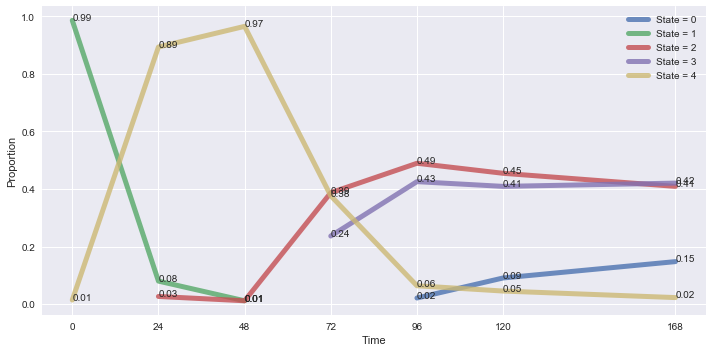

In [85]:
states_evl = np.array(states_freq)
states_evl_pct = []

for x in states_evl:
    states_evl_pct.append(x/x.sum())
    
states_evl_pct = np.array(states_evl_pct)
states_evl_pct[states_evl_pct<=0] = np.nan

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
for j in range(states_evl_pct.shape[1]):
    plt.plot(times, states_evl_pct[:,j], label='State = '+str(states[j]), linewidth=5, alpha=.8)
    for a,b in zip(times, states_evl_pct[:,j]):
        if not np.isnan(b):
            ax.annotate('{:.2f}'.format(b), xy=(a,b))
            
plt.xticks(times)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.tight_layout()

### To do

The third graph is very helpful to infer the trajectory. For example, state 2 is definitely the first state ($T=0$), and it gradually transits to state 1 over time ($T=24$). Over the course $72<T<96$, the proportion of state 1 continues to diminish, while both proportions of state 0 and 4 rise. The problem remains to check if state 0 is transited directly from state 1 or transited from state 4 or both. A clue to verify this is to go back to the gene profiling space to see the similarity of profiles characterising these states. It is reasonably to assume similar states are more likely to transit between each other.